In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250

from cycler import cycler
COLORS = ['#553C67', '#F00D2C', '#4E8F00']
default_cycler = cycler(color=COLORS)
plt.rc('axes', axisbelow=True)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

# Principal Component Analysis

In [2]:
# Load data
data = np.loadtxt('data/perovskite_data.txt')

# Class data - whether we form Perovskite or not
y = data[:, 0]

# Extract all but the 0-th column
X = data[:, 1:]

# Best to center your data when doing PCA
X = (X - np.mean(X, axis=0))/np.std(X, axis = 0)

## Manual SVD Calculation

To understand what's going on under the hood, we'll explicitly calculate the singular vectors -- the "natural" basis of the data. Recall, the singluar vectors of the data matrix $X$ are the Eigenvectors of
$$C = X^T X,$$

In [3]:
# Compute SVD with eigvalue decomposition
C = X.T@X

# General eigenvector calculation
Lambda_eig, U_eig = np.linalg.eig(C)

# We just want the directions of the singular vectors, and not 
# necessarily their magnitude, so we can normalize all vectors
# to have unit length.

# Normalize columns of U_eig
U_eig = U_eig / np.linalg.norm(U_eig, axis=1)

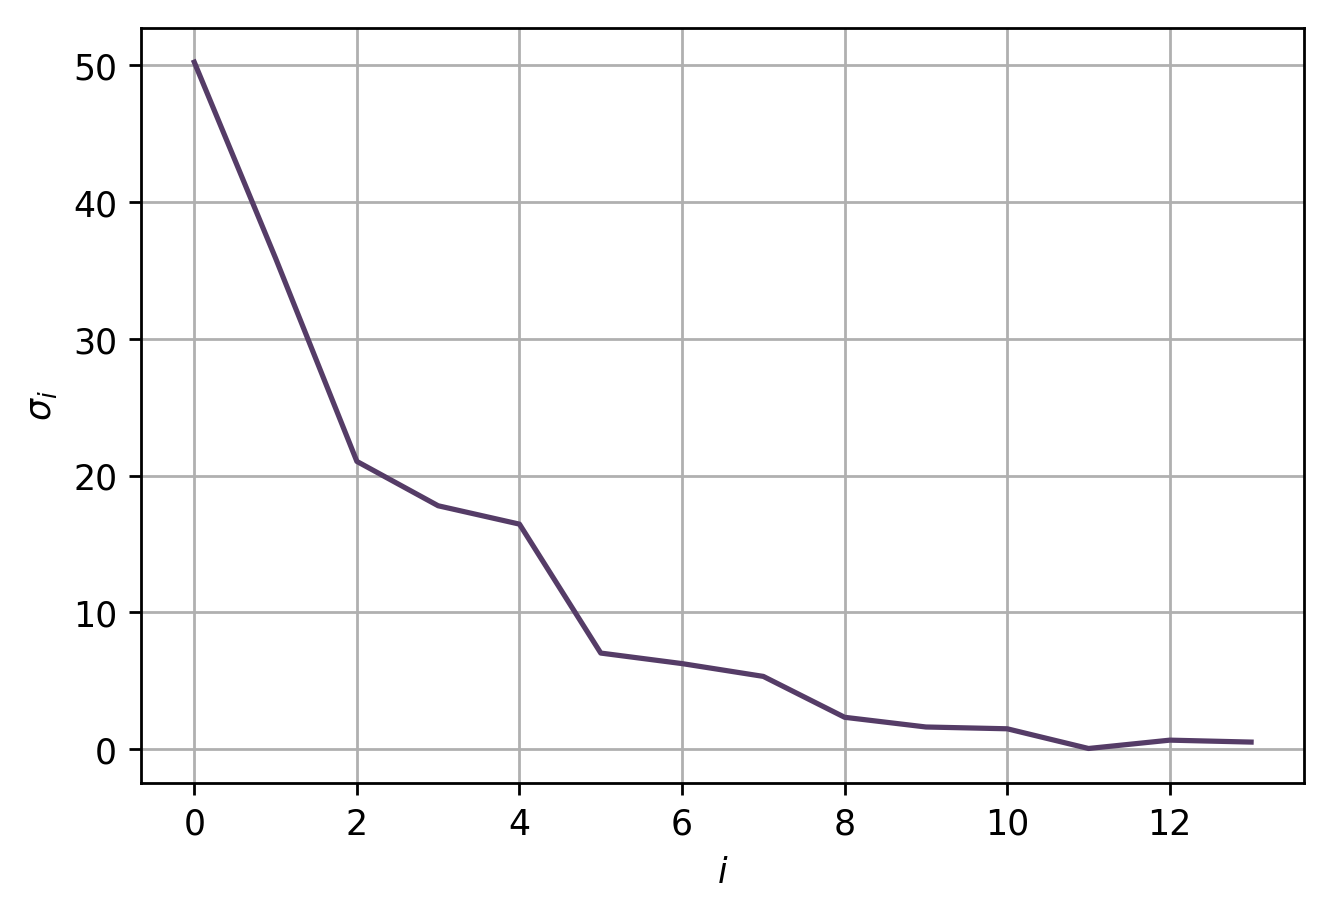

In [6]:
# Plot singular values
Sigma_eig = np.sqrt(Lambda_eig)
plt.plot(Sigma_eig)
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.grid()

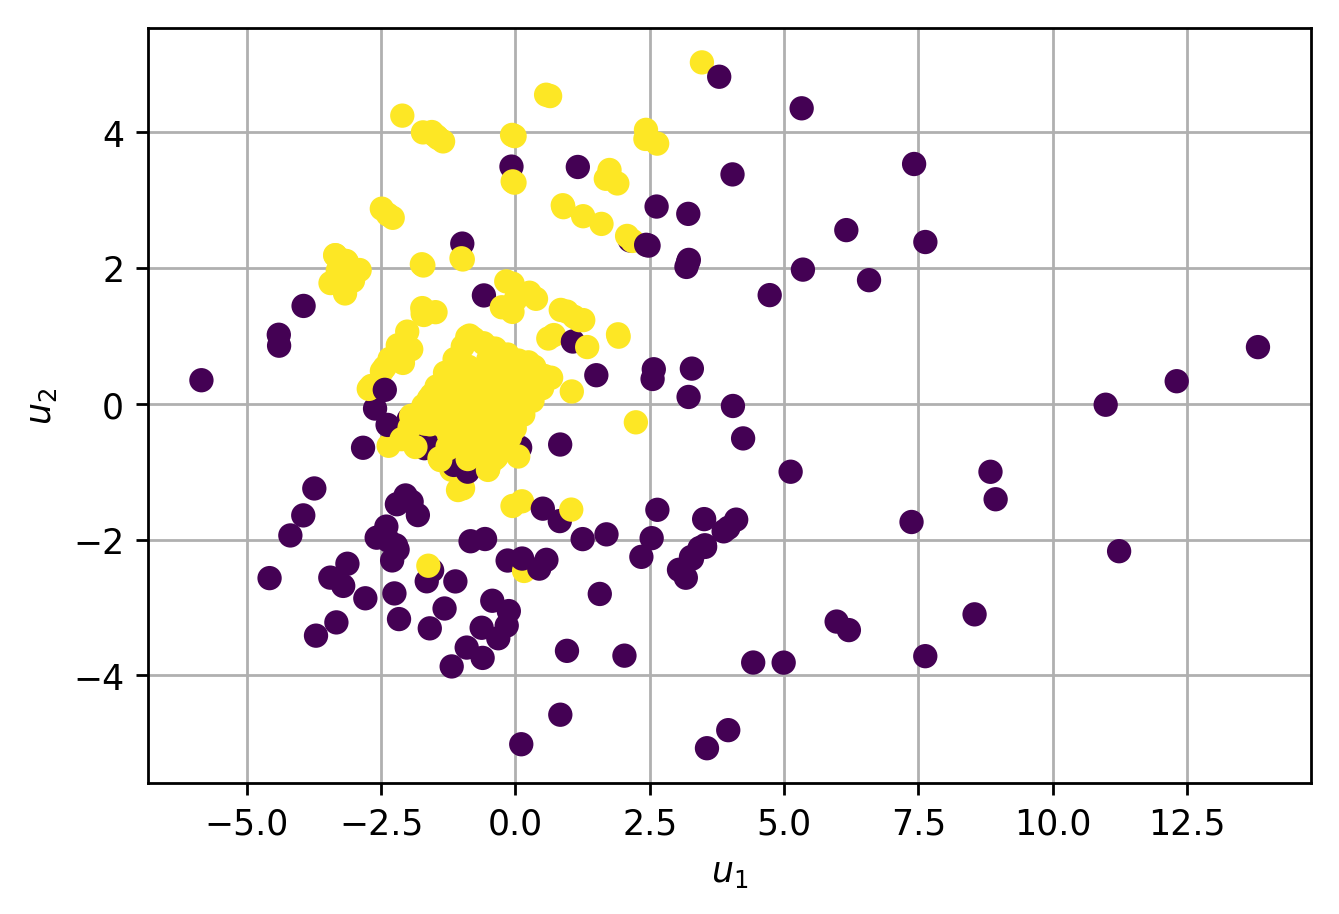

In [7]:
# Let's project our data onto the first largest two singular values
X_proj_EIG = X@U_eig

# Plot first two components
plt.scatter(X_proj_EIG[:, 0], X_proj_EIG[:, 1], c=y)
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.grid()

## SVD calculation using `numpy`

In [ ]:
# use numpy's SVD library:
V, Sigma_np, UT = np.linalg.svd(X, compute_uv=True)
U = UT.T

# Plot singular values
plt.plot(Sigma_np)
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.grid()

In [ ]:
# Let's project our data onto the first two singular values
X_proj_SVD = X@U

# Plot first two components
plt.scatter(X_proj_SVD[:, 0], X_proj_SVD[:, 1], c=y)
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.grid()

## Using `Scikitlearn`

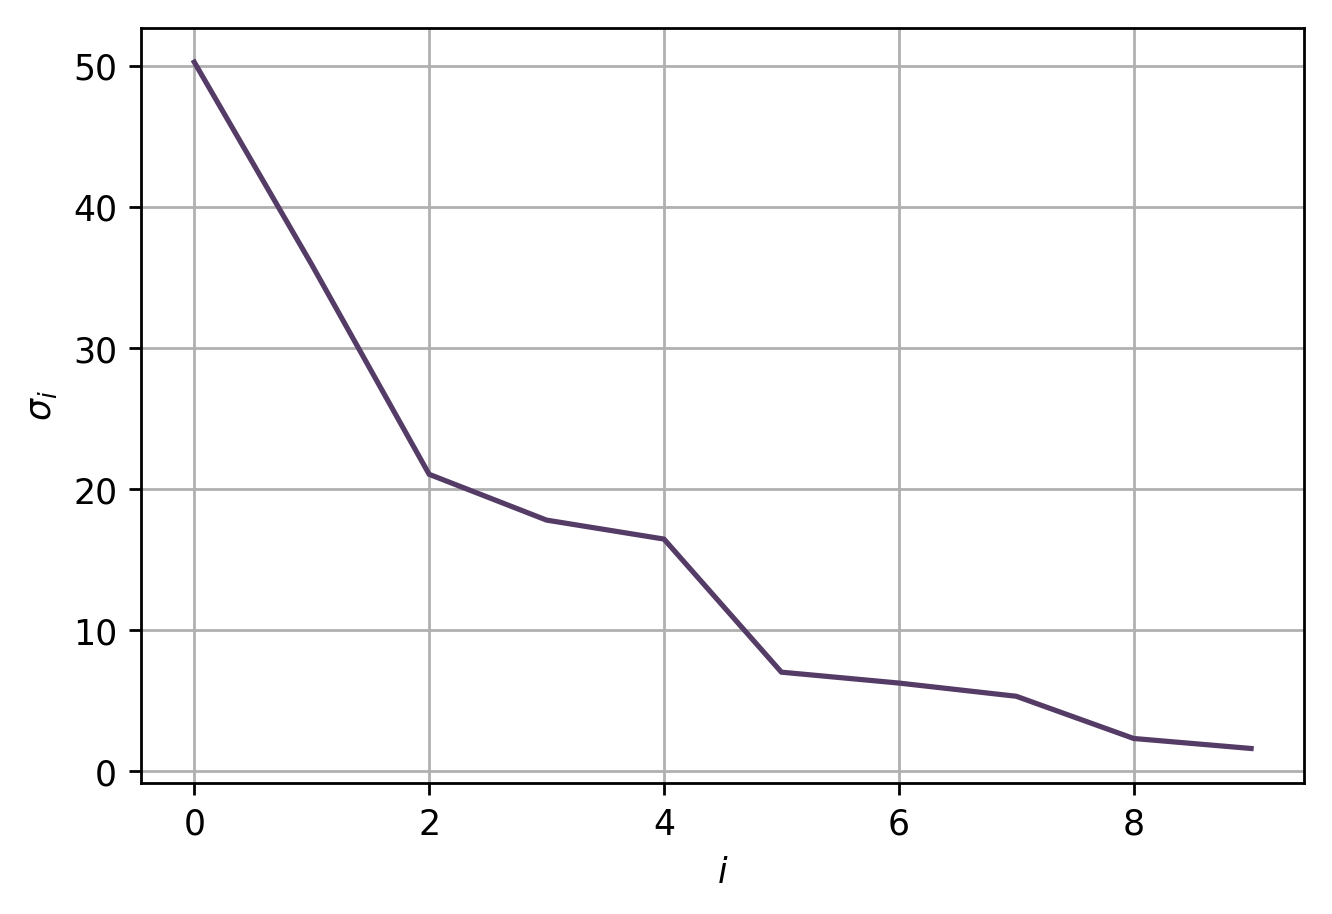

In [9]:
# Use Scikit learn's PCA library
from sklearn.decomposition import PCA

# Create a pca model "object"
pca = PCA(n_components=10)

# Train the model to the data
pca.fit(X)

# Do the dimensionality reduction
X_proj_PCA = pca.transform(X)

# Get singular values
Sigma_PCA = pca.singular_values_ 
plt.plot(Sigma_PCA)
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.grid()

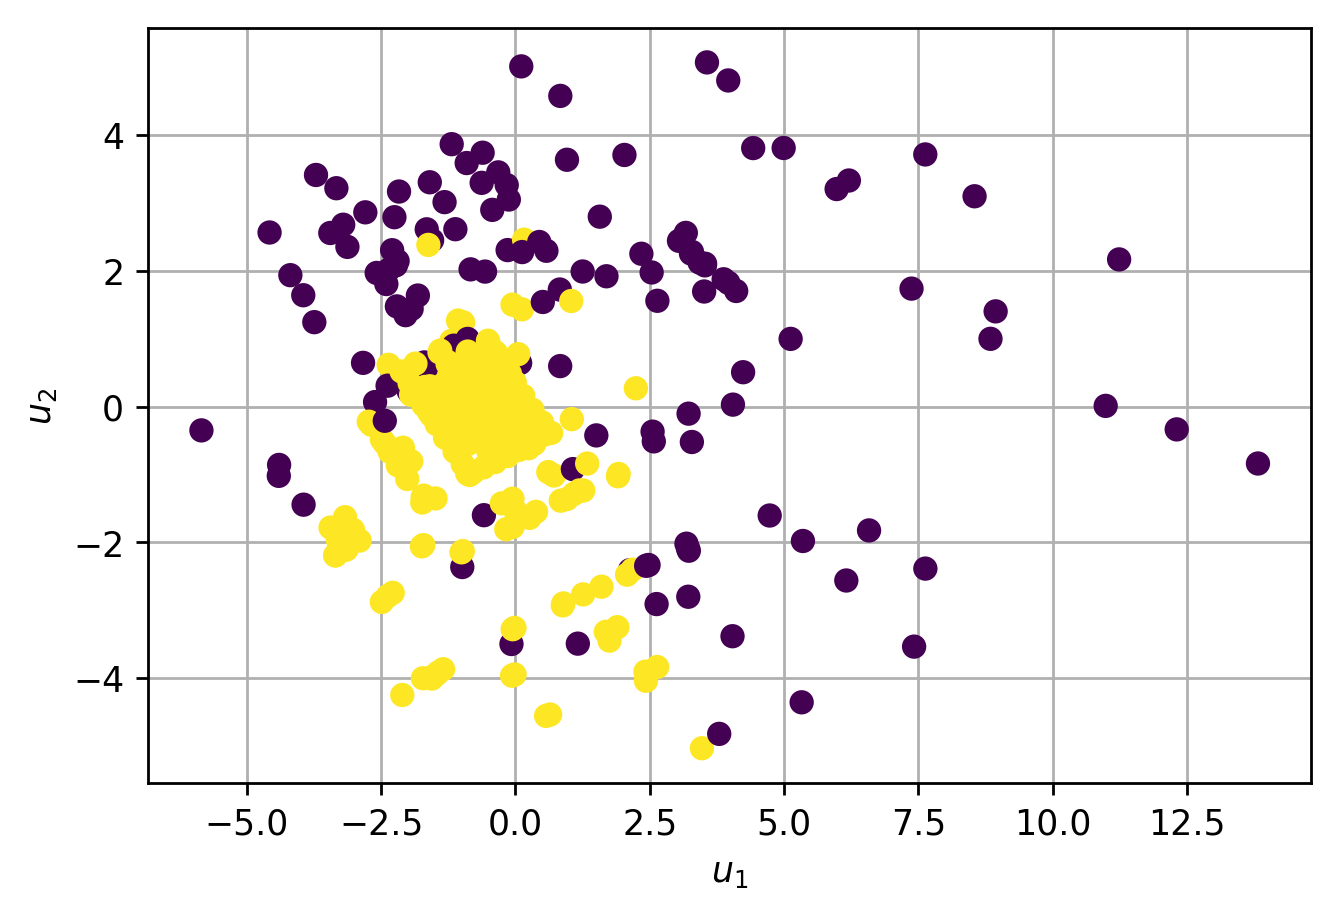

In [10]:
plt.scatter(X_proj_PCA[:, 0], X_proj_PCA[:, 1], c=y)
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.grid()

# Non-linear Manifold Learning

When your data lies in some low-dimensional surface inside its ambient space, but that surface is not linear (i.e. "flat"), then methods like PCA fail to find this low dimensionality of your data.

We have to turn to dimensionality reduction methods for non-flat structures -- this is called **Manifold Learning**.

The `scikitlearn` library has many manifold learning methods available. For details see:

https://scikit-learn.org/stable/modules/manifold.html

To illustrate the various methods, we'll load the "swiss roll" data set, which is data points lying inside a 3 dimensional space, but really essentially lying on a 2 dimensional surface of that space. 

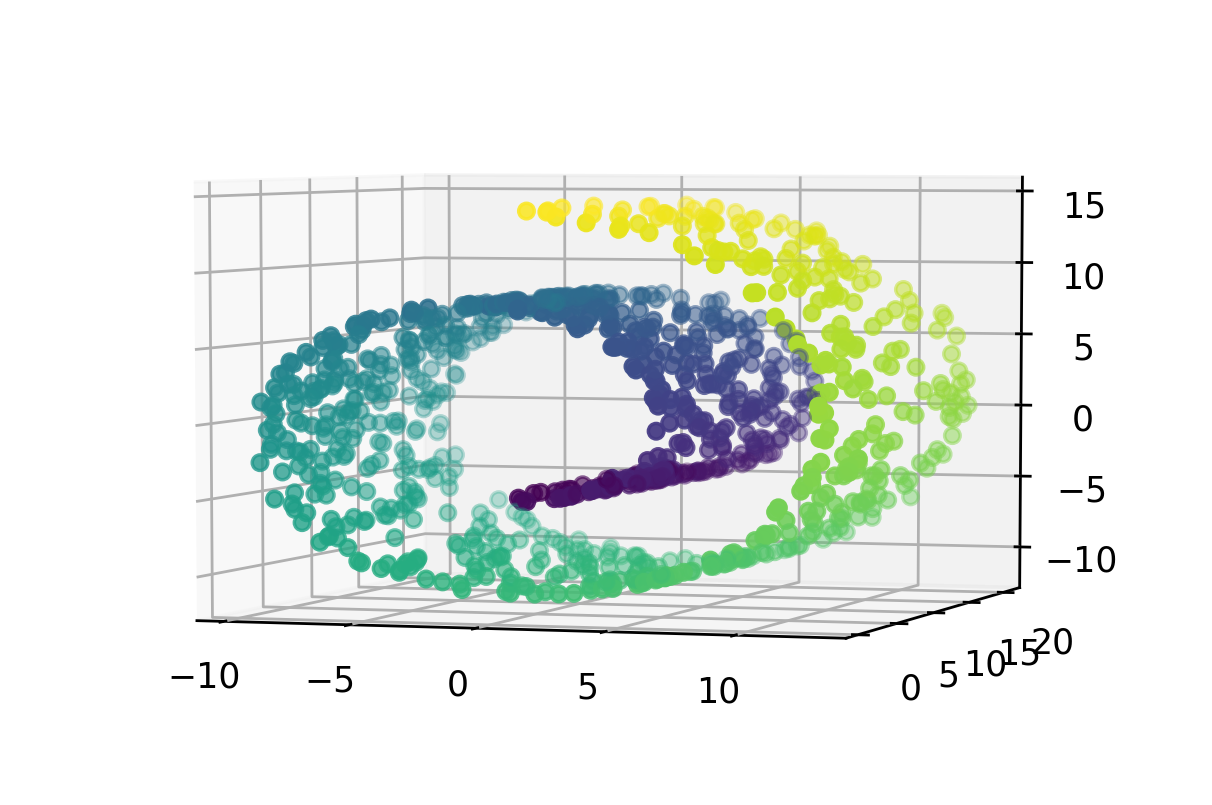

In [11]:
# Generate some nonlinear data
from sklearn import datasets

# Make 3d plots
from mpl_toolkits.mplot3d import Axes3D

NUM_POINTS = 1000
X, color = datasets.samples_generator.make_swiss_roll(NUM_POINTS)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c = color)
ax.view_init(4, -72)

We'd like the dimeninsionality reduction to "capture" this in 2D euclidean space -- i.e. the plane. That is, we're looking for dimensionality reduction algorithms to "unwrap" this and preserve structure as much as possible.

## Linear projections

We'll try some linear projections, which won't be that great because the surface is non-linear. First, we'll just map to the $XY$ plane by forgetting each points' $Z$ coordinate.

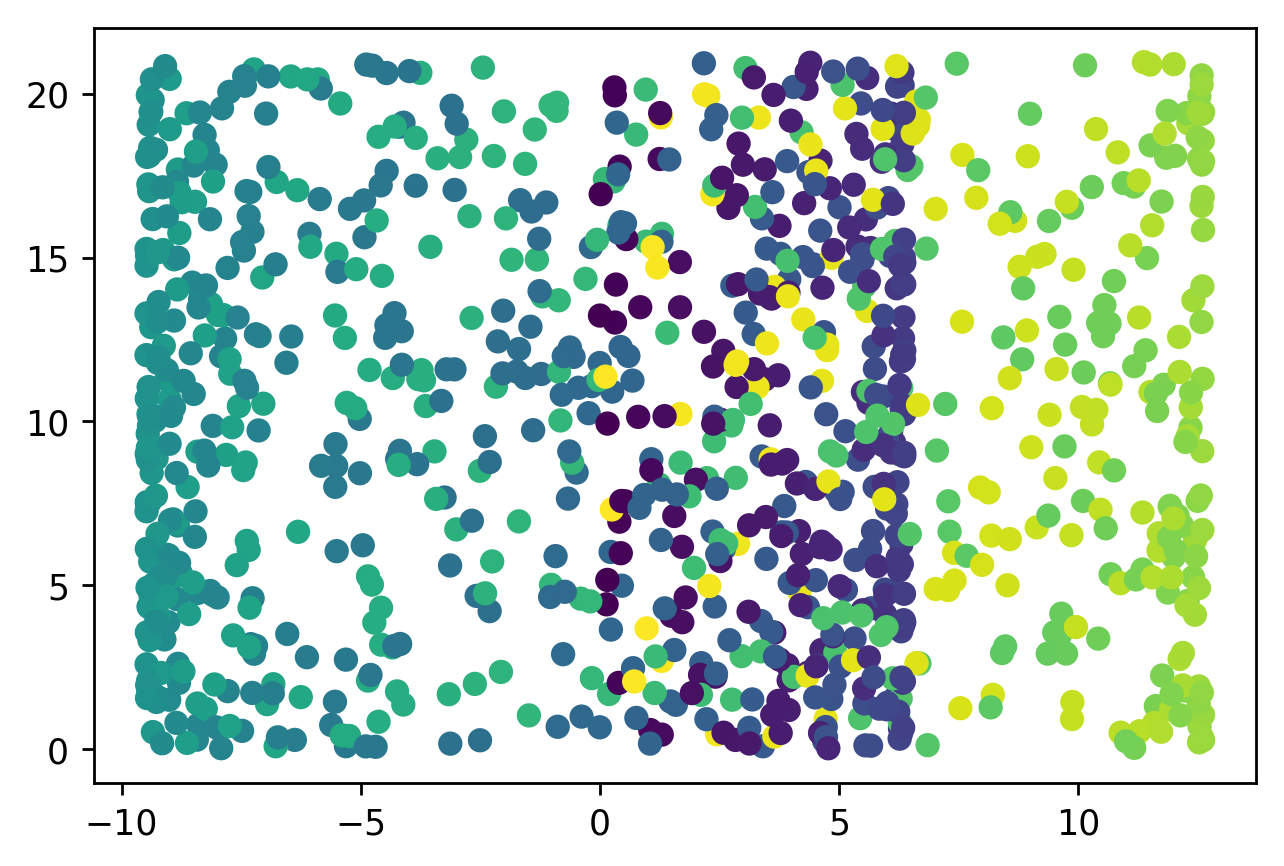

In [12]:
# Plot projetion onto plane z = 0
plt.scatter(X[:,0], X[:,1], c=color)

Now we'll try using PCA, again a linear projection (this time on the plane defined by the first 2 singular vectors).

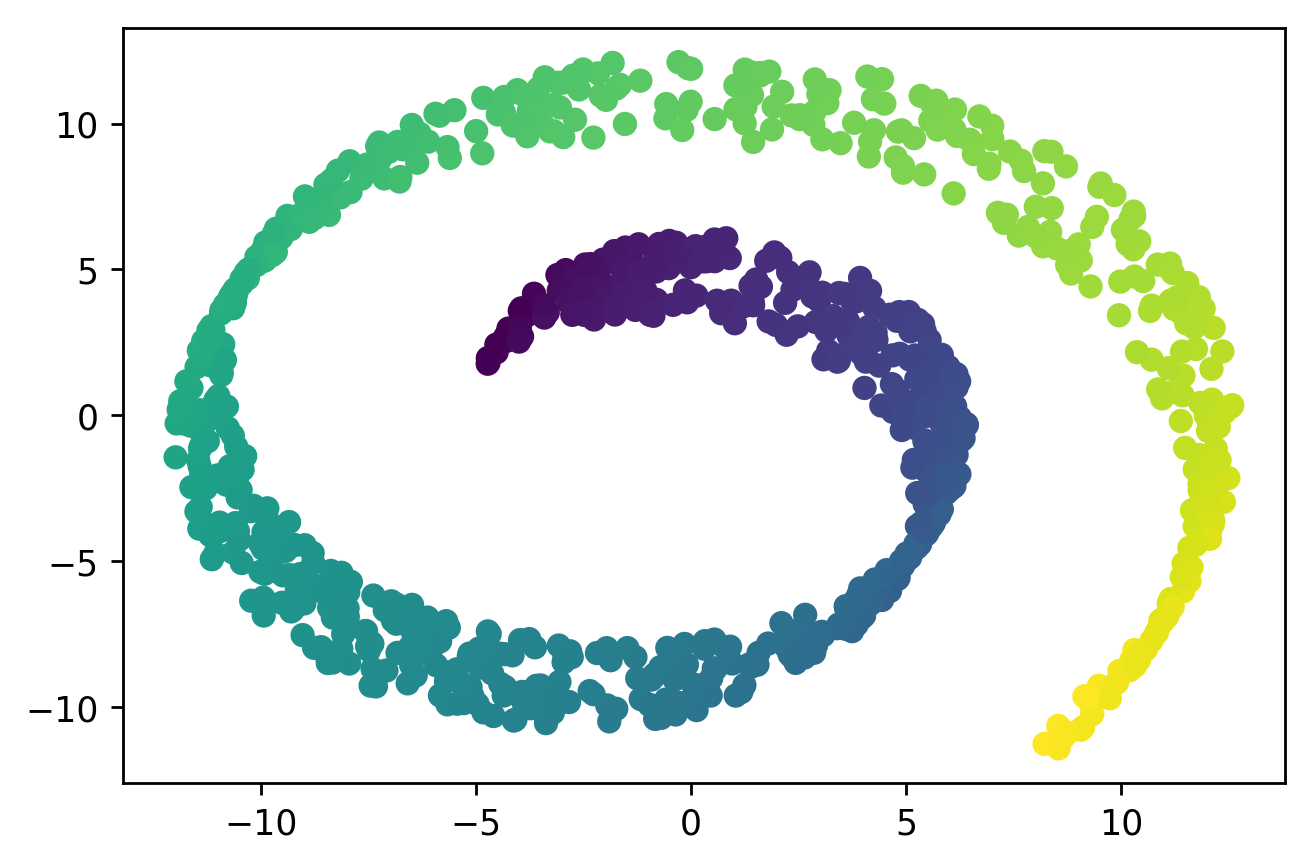

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
Z = pca.transform(X)

plt.scatter(Z[:, 0], Z[:, 1], c=color)

## Kernel PCA

Recall the central idea of kernel PCA is to secretly define a high  non-linear transformation $\phi(\mathbf x)$ - with the hope that that transformation makes the dimensionality reduction easier. In `scikit-learn`, we can use the `KernelPCA` model to do this, and specify what kernel to use.

Documentation:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html

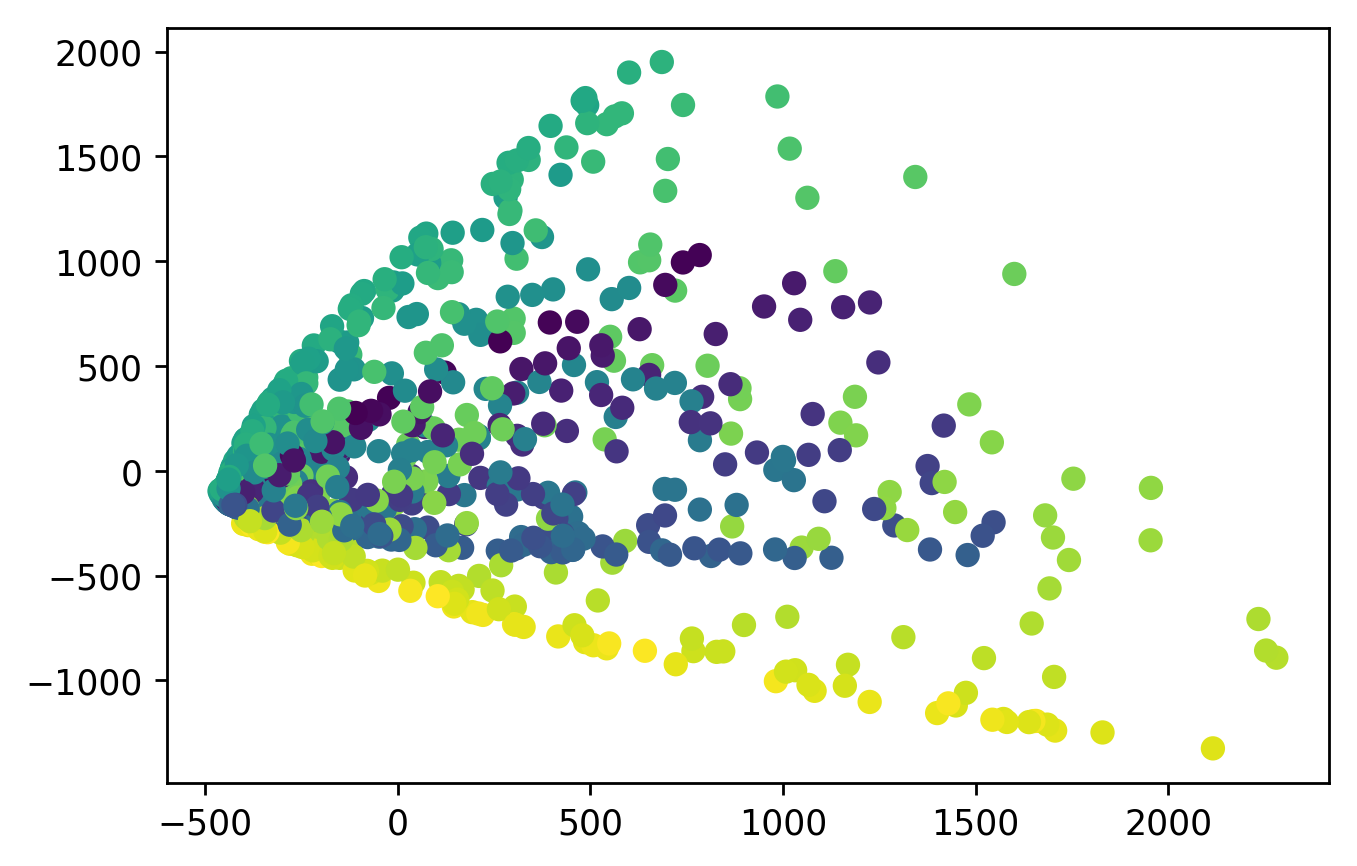

In [15]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2, kernel='poly')
pca.fit(X)
Z = pca.transform(X)

plt.scatter(Z[:, 0], Z[:, 1], c=color)

## Isomap

Recall that Isomap works by trying to fit the points in a low dimensional Euclidean space so that geodesic distance is preserved to the best of our abilities. It approximates the geodesic distance by making a graph of points.

The `Isomap` model in `scikit-learn` does this for your. Among other things, you must specify the number of neighbors in the graph that is built from the points (in `n_neighbors`) as well as the assumed dimension  of the manifold (in `n_components`).

Documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html


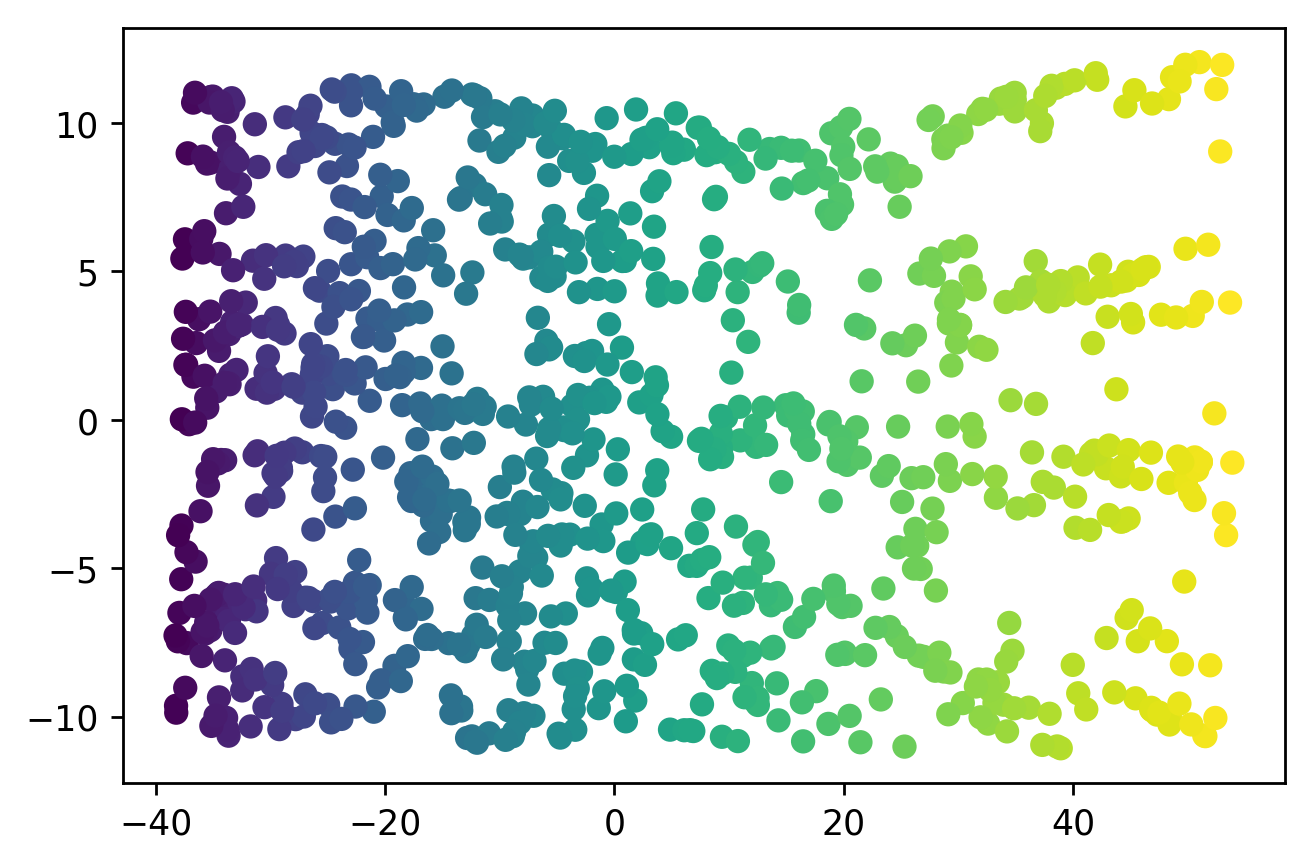

In [16]:
from sklearn.manifold import Isomap

model = Isomap(n_neighbors = 10, n_components = 2)
model.fit(X)
Z = model.transform(X)

plt.scatter(Z[:, 0], Z[:, 1], c=color)

## Other models

`scikit-learn` has many other manifold learning models, and you can look at the documentation for a list of them. Below is just a quick example on a few others.

### Local Linear Embedding

Documentation:
    
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html

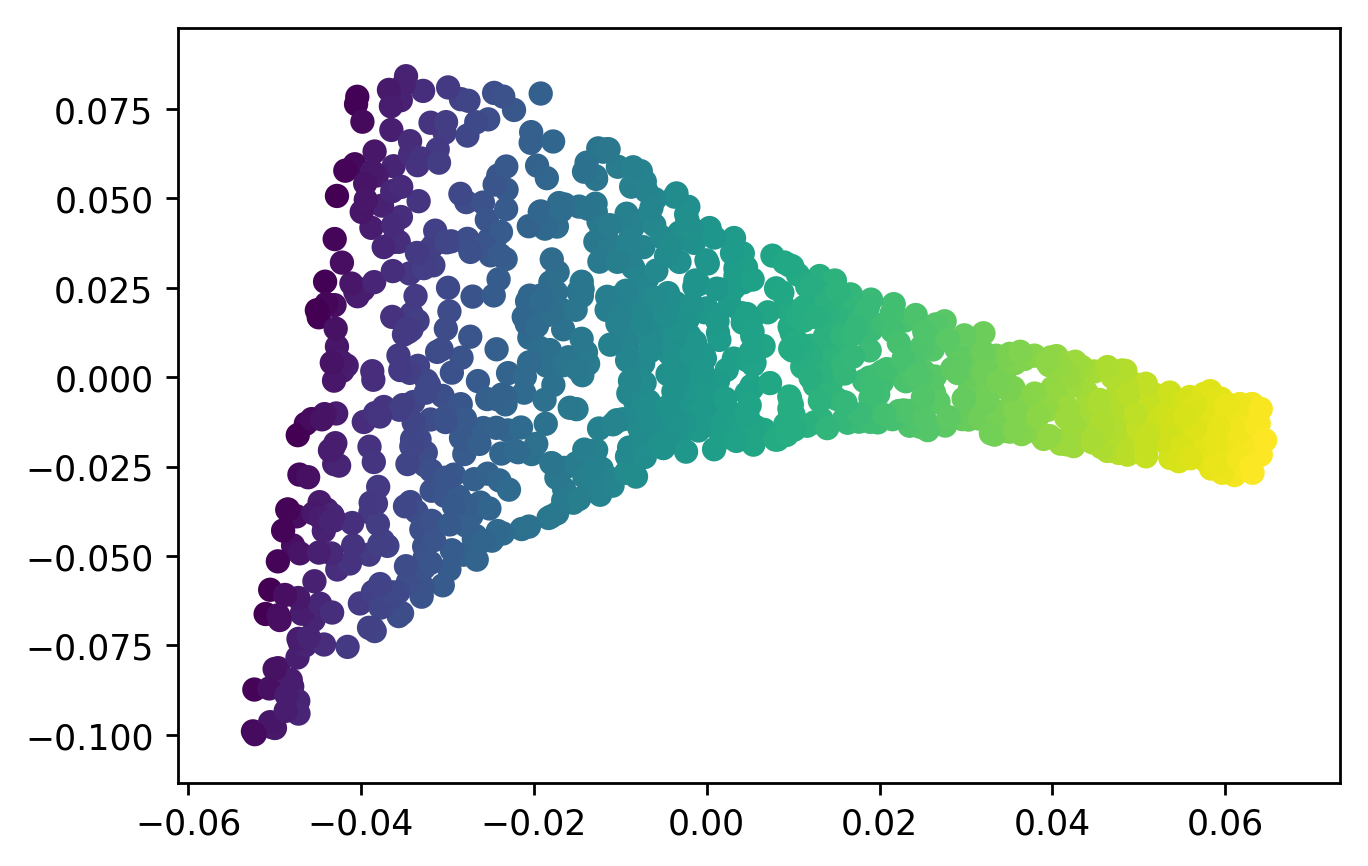

In [17]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(n_neighbors = 10, n_components = 2)
model.fit(X)
Z = model.transform(X)

plt.scatter(Z[:, 0], Z[:, 1], c=color)

### Laplacian Eigenmaps

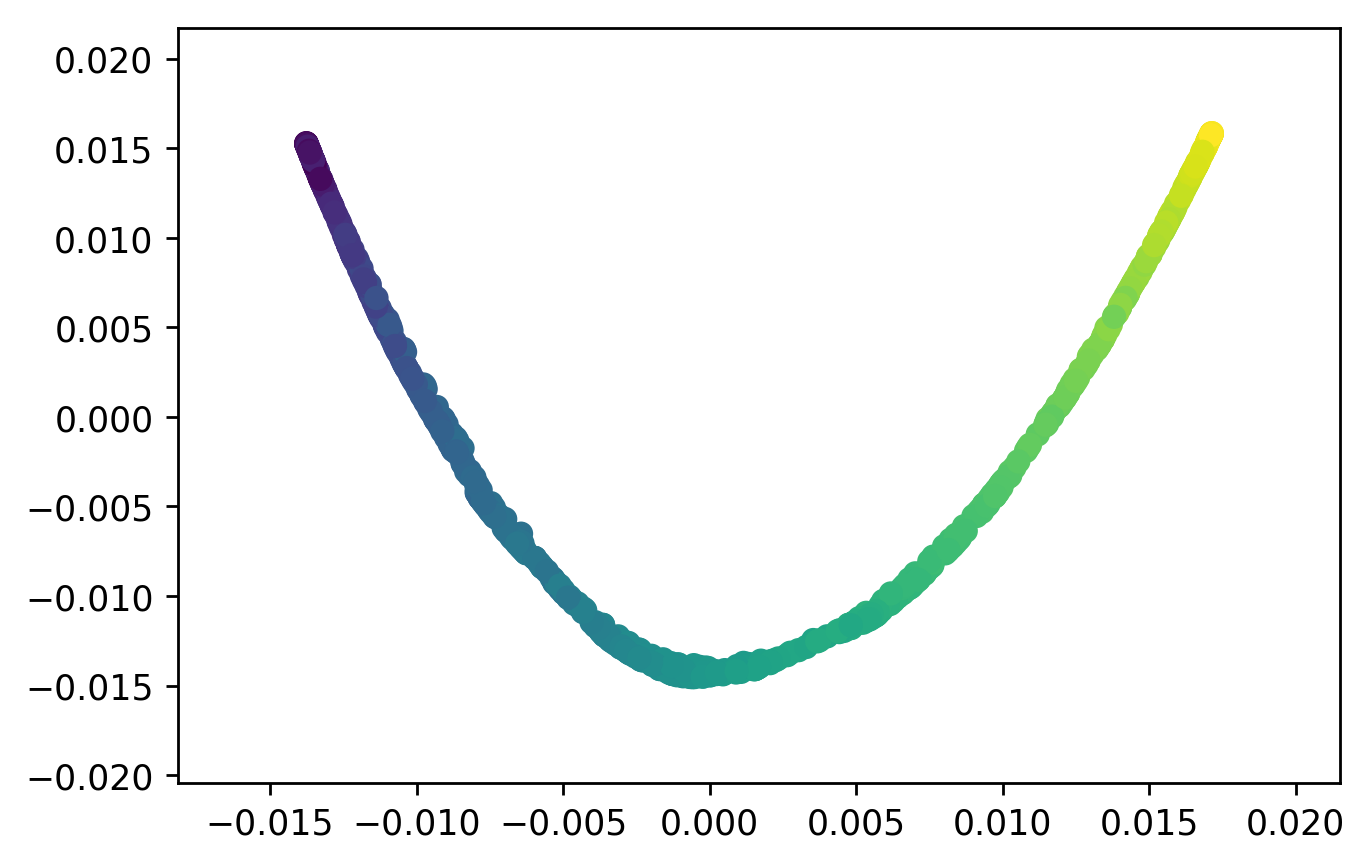

In [18]:
from sklearn.manifold import SpectralEmbedding

model = SpectralEmbedding(n_components = 2, n_neighbors=10)
Z = model.fit_transform(X)

plt.scatter(Z[:, 0], Z[:, 1], c=color)

### Multidimensional Scaling

In [19]:
from sklearn.manifold import MDS

model = MDS(n_components = 2, metric = True)
Z = model.fit_transform(X)

plt.scatter(Z[:, 0], Z[:, 1], c=color)

KeyboardInterrupt: 

### t-distributed Stochastic Neighbor Embedding

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components = 2)
Z = model.fit_transform(X)

plt.scatter(Z[:, 0], Z[:, 1], c=color)